# Lab 2 (Part 2): Regularizing MLPs


------------------------------------------------------
*Deep Learning. Master in Information Health Engineering *

*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this second part of the lab, ou'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world. You can see a sample below.

In [0]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

Our goal is to build a neural network that can take one of these images and predict the digit in the image. Unlike the MNIST case, for this problem you will notice that the model **easily overfits**, so addressing this issue is an important problem here. To do so, we will experiment with early stopping, dropout, and L2 weight regularization.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Part I. Download FMNIST with `torchvision`

The code below will download the MNIST dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [0]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

26427392it [00:05, 4792612.14it/s]                               


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


32768it [00:00, 595399.11it/s]
  1%|          | 40960/4422102 [00:00<00:10, 403684.16it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


4423680it [00:00, 26126208.81it/s]                         
8192it [00:00, 181785.05it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


Lets take a look to the mini-batch size and plot a sample.

In [0]:
testloader.dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /root/.pytorch/F_MNIST_data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [0]:
dataiter = iter(testloader)   #To iterate through the dataset

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

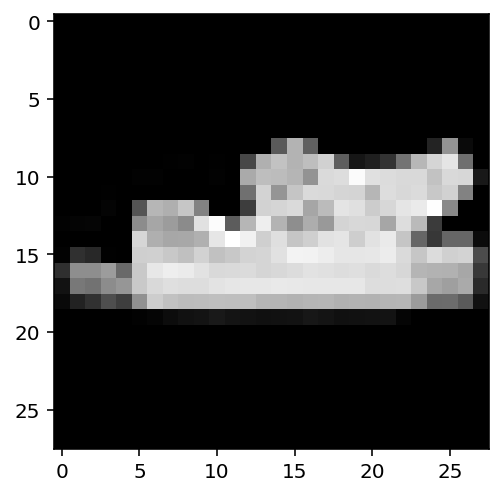

In [0]:
plt.imshow(images[4].numpy().reshape([28,28]), cmap='Greys_r')

## Part II. Visualize overfiting

> **Exercise**: Train a Neural Network with four layers, hidden dimmensions 256, 128 and 64 neurons. Use ReLU activation functions, and a log-Softmax output layer. To do so, complete the following steps: 
> - Create a class defining the NN model 
> - Extend the class to incorporate a training method. **Call it trainloop instead of train**. The reason will be clear later.
> - Train the model for 30 epochs and I) evaluate train/test performance

In [0]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1=256,hidden2=128,hidden3=64, nlabels=10): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,hidden3)
        
        self.output4 = nn.Linear(hidden3,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        
        x = self.relu(self.output1(x))
        x = self.relu(self.output2(x))
        x = self.relu(self.output3(x))
        x = self.logsoftmax(self.output4(x))

        return x

In [0]:
class MLP_extended(MLP):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs,lr):
        super().__init__(dimx,hidden1,hidden2,hidden3, nlabels)
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = []
        
    def trainloop(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                loss = self.criterion(out,labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()              
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:

                probs = self.forward(images.view(images.shape[0], -1))
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [0]:
my_MLP= MLP_extended(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=30,lr=1e-3)

my_MLP.trainloop(trainloader)

train_performance = my_MLP.eval_performance(trainloader)

test_performance = my_MLP.eval_performance(testloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

Training loss after 0 epochs: 0.518774
Training loss after 1 epochs: 0.378875
Training loss after 2 epochs: 0.337647
Training loss after 3 epochs: 0.314299
Training loss after 4 epochs: 0.293740
Training loss after 5 epochs: 0.278344
Training loss after 6 epochs: 0.264342
Training loss after 7 epochs: 0.250643
Training loss after 8 epochs: 0.241162
Training loss after 9 epochs: 0.230005
Training loss after 10 epochs: 0.222182
Training loss after 11 epochs: 0.210046
Training loss after 12 epochs: 0.202749
Training loss after 13 epochs: 0.195640
Training loss after 14 epochs: 0.186742
Training loss after 15 epochs: 0.178985
Training loss after 16 epochs: 0.170786
Training loss after 17 epochs: 0.162670
Training loss after 18 epochs: 0.155749
Training loss after 19 epochs: 0.153141
Training loss after 20 epochs: 0.143550
Training loss after 21 epochs: 0.140625
Training loss after 22 epochs: 0.135820
Training loss after 23 epochs: 0.129456
Training loss after 24 epochs: 0.125237
Training l

In [0]:
torch.save(my_MLP.state_dict(), 'checkpoint.pth')
my_MLP.state_dict().keys()

odict_keys(['output1.weight', 'output1.bias', 'output2.weight', 'output2.bias', 'output3.weight', 'output3.bias', 'output4.weight', 'output4.bias'])

In light of the train/test performance, certainly the model is performing significantly better in the train set than in the test set. This is a sign of overfitting. For an early detection of overfitting, we will make use of a **validation set** that we will use to visualize the evolution of the loss function during training. 

With the following code we split the train set into one training set (45k images) and a validation set (15k images). We do a naive splitting assuming that the data is randomized. **Keep in mind that in general you can do something smarter than this like K-Fold cross validation**, but here we keep it simple.



In [0]:
import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

> **Exercise**: Modify your code class above so that, during training, everytime an epoch is finished you compute the loss function over the validation set. You must store these values into a list name as `valid_loss_during_training`. When performing this step, do not forget to turn off gradients by using `with torch.no_grad()`.
>
>Then, repeat the training (30 epochs) and plot the train/validation loss along epochs

In [0]:
class MLP_extended(MLP):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs,lr):
        super().__init__(dimx,hidden1,hidden2,hidden3, nlabels)
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = []
        
        self.valid_loss_during_training = []
        
    def trainloop(self,trainloader, validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                loss = self.criterion(out,labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()              
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            val_running_loss = 0
            
            for images, labels in validloader:              # NEW w.r.t Lab 1
                
                val_out = self.forward(images.view(images.shape[0], -1))

                val_loss = self.criterion(val_out,labels)

                val_running_loss += val_loss.item()            
                
            self.valid_loss_during_training.append(val_running_loss/len(validloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1]))
               
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:

                probs = self.forward(images.view(images.shape[0], -1))
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [0]:
my_MLP = MLP_extended(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=30,lr=1e-3)

my_MLP.trainloop(trainloader,validloader)

train_performance = my_MLP.eval_performance(trainloader)

test_performance = my_MLP.eval_performance(validloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

Training loss after 0 epochs: 0.437826
Training loss after 1 epochs: 0.386886
Training loss after 2 epochs: 0.390059
Training loss after 3 epochs: 0.340341
Training loss after 4 epochs: 0.350282
Training loss after 5 epochs: 0.326396
Training loss after 6 epochs: 0.337567
Training loss after 7 epochs: 0.336343
Training loss after 8 epochs: 0.329102
Training loss after 9 epochs: 0.326786
Training loss after 10 epochs: 0.328382
Training loss after 11 epochs: 0.342733
Training loss after 12 epochs: 0.346177
Training loss after 13 epochs: 0.338460
Training loss after 14 epochs: 0.367760
Training loss after 15 epochs: 0.360664
Training loss after 16 epochs: 0.353709
Training loss after 17 epochs: 0.368661
Training loss after 18 epochs: 0.391412
Training loss after 19 epochs: 0.376422
Training loss after 20 epochs: 0.418640
Training loss after 21 epochs: 0.388325
Training loss after 22 epochs: 0.423195
Training loss after 23 epochs: 0.435892
Training loss after 24 epochs: 0.407117
Training l

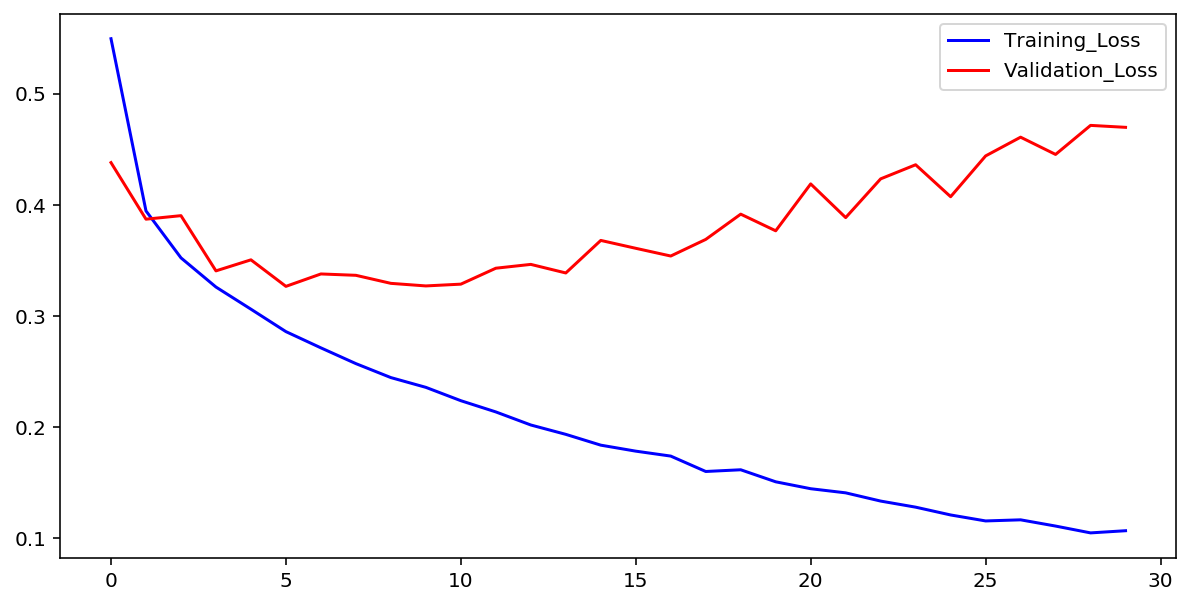

In [0]:
loss_tr = np.asarray(my_MLP.loss_during_training)
loss_val = np.asarray(my_MLP.valid_loss_during_training)
e=np.arange(0,30,1)
plt.figure(figsize=(10,5))
plt.plot(e,loss_tr,'b', label='Training_Loss')
plt.plot(e,loss_val,'r', label='Validation_Loss')
plt.legend()
plt.show()

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting. 

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss. **Note that with early stopping we are using the validation set to select the appropiate number of epochs.

> **Exercise:** According to your results, re-train the model again for the right number of epochs (just before the validation loss starts to grow). Compare the train, validation and test performance.

In [0]:
my_MLP = MLP_extended(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=7,lr=1e-3)

my_MLP.trainloop(trainloader,validloader)

train_performance = my_MLP.eval_performance(trainloader)

test_performance = my_MLP.eval_performance(validloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

Training loss after 0 epochs: 0.458590
Training loss after 1 epochs: 0.387409
Training loss after 2 epochs: 0.354575
Training loss after 3 epochs: 0.369440
Training loss after 4 epochs: 0.355870
Training loss after 5 epochs: 0.346402
Training loss after 6 epochs: 0.335703
Train Accuracy 0.908469
Test Accuracy 0.881671


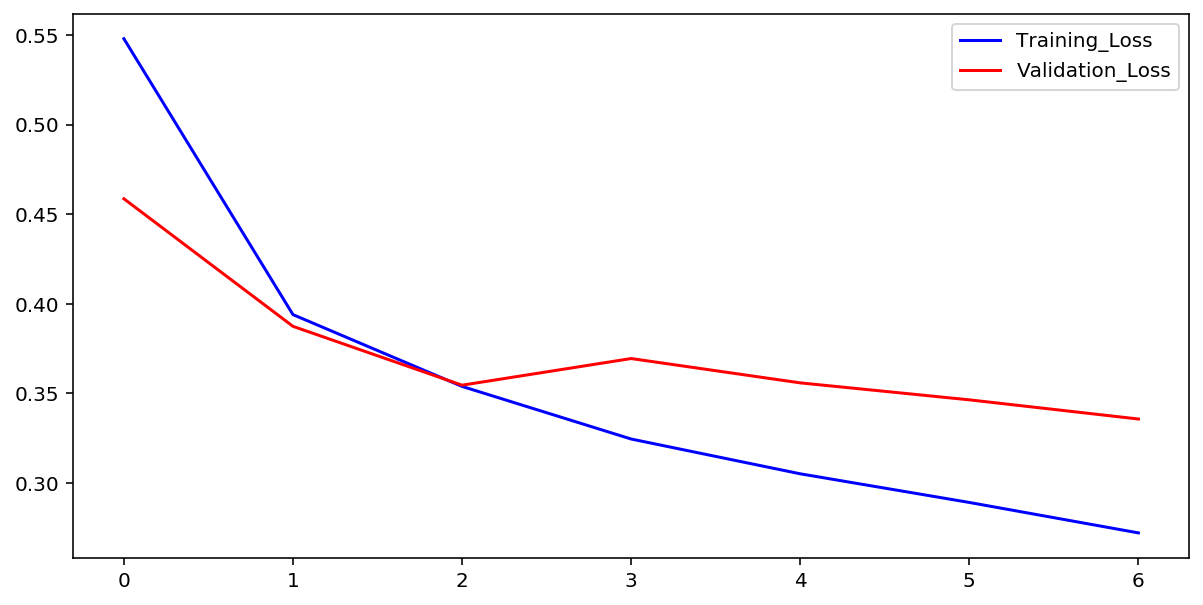

In [0]:
loss_tr = np.asarray(my_MLP.loss_during_training)
loss_val = np.asarray(my_MLP.valid_loss_during_training)
e=np.arange(0,7,1)
plt.figure(figsize=(10,5))
plt.plot(e,loss_tr,'b', label='Training_Loss')
plt.plot(e,loss_val,'r', label='Validation_Loss')
plt.legend()
plt.show()

## Part III. Using Dropout Regularization

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

The following code corresponds to a 2 layer NN where we use dropout in the intermediate hidden space:


```python
class MLP_dropout(nn.Module):
    def __init__(self,dimx,hidden1,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)  
        
        self.output2 = nn.Linear(hidden1,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)  
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `self.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `self.train()` (**This is why we cannot call our training method `train` anymore**). In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    self.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
self.train()
```

> **Exercise:** 
> - Create a new NN class that modifies the previous one by incorporating a dropout step with `p=0.2`  after every ReLU non-linearity is applied. 
> - Modified the extended clases to set `model.eval()` when appropiate (do not forget to go back to `model.train()`)
> - For this new model, plot the evolution of the training and validation losses. Compare with the case with no dropout. Discuss the results. Is early stopping still required? If so, when you should stop training? Compare the train, validation and test performance.
> - Repeat the experiments for a dropout probability of `p=0.1` and `p=0.3`. Which value provides the best validation performance? 

In [0]:
class MLP_dropout(nn.Module):
    def __init__(self,dimx,hidden1=256,hidden2=128,hidden3=64,nlabels=10,p=0.2): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,hidden3)
        
        self.output4 = nn.Linear(hidden3,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        
        x = self.relu(self.output1(x)x)
        x = self.dropout(x)
        x = self.relu(self.output2(x))
        x = self.dropout(x)
        x = self.relu(self.output3(x))
        x = self.dropout(x)
        x = self.logsoftmax(self.output4(x))
        
        return x

In [0]:
class MLP_extended(MLP_dropout):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,p,epochs,lr):
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels,p)
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()          
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = []
        
        # A list to store the loss evolution along validation
        
        self.valid_loss_during_training = []
        
        
    def trainloop(self,trainloader, validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                loss = self.criterion(out,labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()              
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # turn off gradients
            with torch.no_grad():
              
              self.eval()
              
              val_running_loss = 0
              
              for images, labels in validloader:
                
                val_out = self.forward(images.view(images.shape[0], -1))

                val_loss = self.criterion(val_out,labels)

                val_running_loss += val_loss.item() 
                
              self.valid_loss_during_training.append(val_running_loss/len(validloader))

            self.train()
            
            acc = self.eval_performance(validloader)              
                                     
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:

                probs = self.forward(images.view(images.shape[0], -1))
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [0]:
my_MLP_dropout_1 = MLP_extended(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,p=0.1, epochs=30,lr=1e-3) 
my_MLP_dropout_2 = MLP_extended(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,p=0.2, epochs=30,lr=1e-3)
my_MLP_dropout_3 = MLP_extended(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,p=0.3, epochs=30,lr=1e-3)

my_MLP_dropout_1.trainloop(trainloader,validloader)
my_MLP_dropout_2.trainloop(trainloader,validloader)
my_MLP_dropout_3.trainloop(trainloader,validloader)

train_performance_1 = my_MLP_dropout_1.eval_performance(trainloader)
train_performance_2 = my_MLP_dropout_2.eval_performance(trainloader)
train_performance_3 = my_MLP_dropout_3.eval_performance(trainloader)

val_performance_1 = my_MLP_dropout_1.eval_performance(validloader)
val_performance_2 = my_MLP_dropout_2.eval_performance(validloader)
val_performance_3 = my_MLP_dropout_3.eval_performance(validloader)

test_performance_1 = my_MLP_dropout_1.eval_performance(testloader)
test_performance_2 = my_MLP_dropout_2.eval_performance(testloader)
test_performance_3 = my_MLP_dropout_3.eval_performance(testloader)

print("For p = 0.1\n Train Accuracy = %f, Validation Accuracy = %f, Test Accuracy = %f \n" %(train_performance_1, val_performance_1, test_performance_1))
print("For p = 0.2\n Train Accuracy = %f, Validation Accuracy = %f, Test Accuracy = %f \n" %(train_performance_2, val_performance_2, test_performance_2))
print("For p = 0.3\n Train Accuracy = %f, Validation Accuracy = %f, Test Accuracy = %f" %(train_performance_3, val_performance_3, test_performance_3))

For p = 0.1
 Train Accuracy = 0.936990, Validation Accuracy = 0.885217, Test Accuracy = 0.874204 

For p = 0.2
 Train Accuracy = 0.922496, Validation Accuracy = 0.879388, Test Accuracy = 0.871218 

For p = 0.3
 Train Accuracy = 0.906561, Validation Accuracy = 0.873737, Test Accuracy = 0.867436


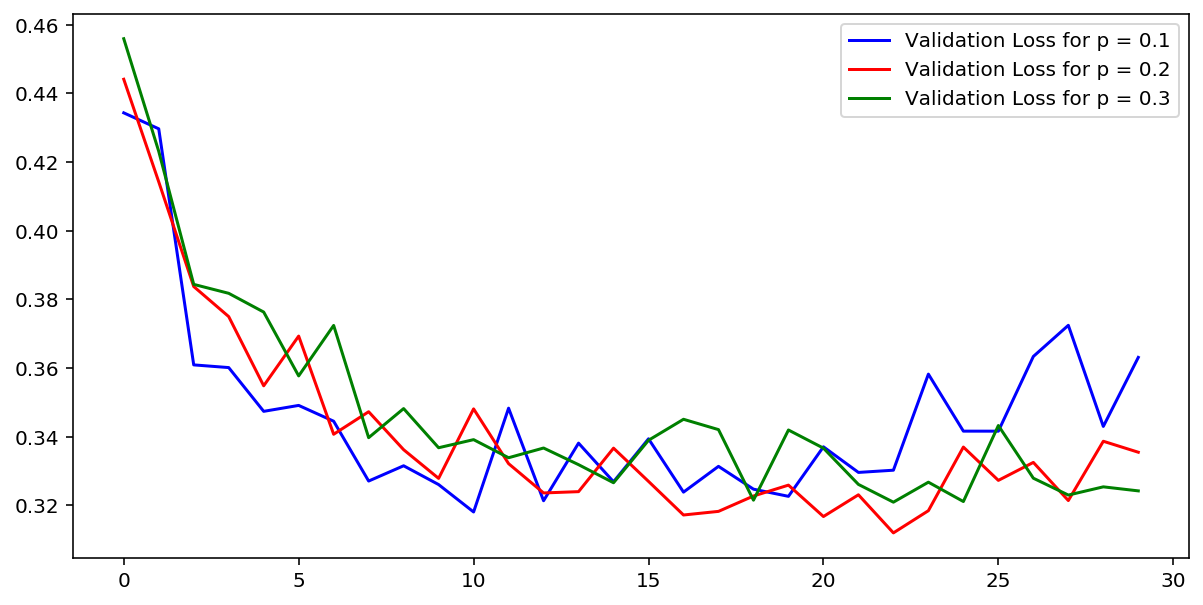

In [0]:
loss_1 = np.asarray(my_MLP_dropout_1.valid_loss_during_training)
loss_2 = np.asarray(my_MLP_dropout_2.valid_loss_during_training)
loss_3 = np.asarray(my_MLP_dropout_3.valid_loss_during_training)

epochs = np.arange(0, 30, 1)

plt.figure(figsize=(10,5))
plt.plot(epochs, loss_1,'b', label='Validation Loss for p = 0.1')
plt.plot(epochs, loss_2,'r', label='Validation Loss for p = 0.2')
plt.plot(epochs, loss_3,'g', label='Validation Loss for p = 0.3')
plt.legend()
plt.show()

Now we just look for the minimum between all the validation losses in order to choose the best value of p.

In [0]:
print('The minimum loss for each value of p is:\n')
print('p = 0.1 -> %f' %(min(loss_1)))
print('p = 0.2 -> %f' %(min(loss_2)))
print('p = 0.3 -> %f' %(min(loss_3)))

The minimum loss for each value of p is:

p = 0.1 -> 0.318102
p = 0.2 -> 0.312008
p = 0.3 -> 0.320955


Taking into account that the dropout makes overfitting harder, we also need to estimate the probability of the dropout for a fixed number of epochs (30 in this case). In our experiment, we can see that p=0.2 has the best performance, but a value of p = 0.3 the trainning is also slower and we'll probably need more epochs to get an accurate solution.